In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [64]:
cd ../src

/home/theo/Kaggle/clouds/src


In [3]:
from util import *
from params import *
from metric import *
from params import *
from imports import *
from post_process import *

In [65]:
from data.masks import *
from data.dataset import *
from data.lower_res import *
from data.transforms import *

In [5]:
from training.train import *
from training.freezing import *
from training.predicting import *

In [6]:
from model_zoo.unet import *
from model_zoo.fpn_enetb5 import *
from model_zoo.unet_densenet169 import *
from model_zoo.unet_seresnext50 import *

In [7]:
from tqdm import tqdm_notebook as tqdm

sns.set_style('white')
KERNEL_START_TIME = time.time()
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=RuntimeWarning)
print('Number of available cores :', multiprocessing.cpu_count())
seed_everything(seed)

Number of available cores : 16


# Parameters

In [8]:
k = 4
selected_fold = 3

In [94]:
TEST_IMG_PATH = '../input/test_images_2/'
TRAIN_IMG_PATH = '../input/train_images_2/'
MASK_DIC_PATH = DATA_PATH + 'train_2.csv'

In [10]:
CP_FOLDER = '../checkpoints/used_cps/v3/'

In [11]:
MASKS_PATH = f'../masks/{date.today()}_{selected_fold + 1}/'

if not os.path.exists(MASKS_PATH ):
    os.mkdir(MASKS_PATH )

In [12]:
tta = True
aux_clf = False

# Data

In [13]:
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_train['EncodedPixels'].fillna('-1', inplace=True)

print('Number of training images : ', len(df_train) // 4)

Number of training images :  5546


In [14]:
present_classes = df_train['EncodedPixels'].values.reshape(-1, 4)
present_classes = np.where(present_classes != '-1', 1, 0)
class_count = np.sum(present_classes, axis=0)

In [15]:
_, rep_classes = get_mask_dic(pd.read_csv(MASK_DIC_PATH), return_images=True)
all_images = rep_classes.index.values

In [16]:
mask_dic = get_mask_dic(pd.read_csv(MASK_DIC_PATH))

# Retrieving Folds

In [17]:
probs_dic = {}

In [18]:
present_classes = np.array([present_classes[i] for i in range(len(present_classes)) if all_images[i] not in CORRUPTED])
all_images = np.array([img for img in all_images if img not in CORRUPTED])

encoded_classes = present_classes[:, 0] * 8 + present_classes[:, 1] * 4 + present_classes[:, 2] * 2 + present_classes[:, 0]

In [19]:
splits = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=seed).split(all_images, encoded_classes))
val_idx = splits[selected_fold][1]

In [20]:
val_dataset = CloudValDataset(mask_dic, all_images[val_idx], present_classes[val_idx], img_path=TRAIN_IMG_PATH)

# Retrieving models

In [37]:
tta = True
use_aux_clf = True

In [22]:
models = []

In [23]:
os.listdir('../checkpoints/used_cps/v3/')

['unet_se_resnext50_32x4d_4_3_shadow_cp.pt',
 'faults_pred_1_pl.npy',
 'faults_max_4_pl.npy',
 'unet_se_resnext50_32x4d_3_3_shadow_cp.pt',
 'faults_pred_4_pl.npy',
 'faults_max_1_pl.npy',
 'faults_max_3_pl.npy',
 'faults_max_2_pl.npy',
 'unet_se_resnext50_32x4d_1_3_shadow_cp.pt',
 'unet_se_resnext50_32x4d_4_2_shadow_cp.pt',
 'unet_se_resnext50_32x4d_2_3_shadow_cp.pt',
 'unet_se_resnext50_32x4d_1_2_shadow_cp.pt',
 'faults_pred_3_pl.npy',
 'unet_se_resnext50_32x4d_2_2_shadow_cp.pt',
 'faults_pred_2_pl.npy',
 'unet_se_resnext50_32x4d_3_2_shadow_cp.pt']

In [24]:
backbone = 'se_resnext50_32x4d'
weights =  f'unet_se_resnext50_32x4d_{selected_fold + 1}_2_shadow_cp.pt'

# weights ='unet_se_resnext50_32x4d_1_3_shadow_cp.pt'
# ../checkpoints/2019-11-11/unet_se_resnext50_32x4d_1_3.pt

model = SegmentationUnet(SETTINGS[backbone], num_classes=4, center_block="aspp", aux_clf=True).to(DEVICE)
model = load_model_weights(model, weights, verbose=1, cp_folder=CP_FOLDER)

models.append(model)


 -> Loading weights from ../checkpoints/used_cps/v3/unet_se_resnext50_32x4d_4_2_shadow_cp.pt



In [25]:
print(f'Using {len(models)} models for segmentation')

Using 1 models for segmentation


# Retriving classifier predictions

In [26]:
# PROBS = np.load('insert_aux_clf_probs')
PROBS = np.ones((len(all_images), 4))

PROBS_VAL = PROBS[val_idx]

prob_thresholds = [0.5, 0.5, 0.5, 0.5]

# Params

In [27]:
t = 1

In [28]:
prob_thresholds_max = [0] * 4

# Auxiliary  Classifier

In [34]:
try:
    faults_pred = np.load(f"{CP_FOLDER}faults_pred_{selected_fold + 1}.npy")
    faults_max = np.load(f"{CP_FOLDER}faults_max_{selected_fold + 1}.npy")
    
    print('Probabilities loaded.')
    
except:
    print('Generating probabilities ... \n')
    faults_pred, faults_max = predict_and_save(val_dataset, model, all_images[val_idx], tta=tta, img_folder=MASKS_PATH)
    
    np.save(f"{CP_FOLDER}faults_pred_{selected_fold + 1}_pl.npy", faults_pred)
    np.save(f"{CP_FOLDER}faults_max_{selected_fold + 1}_pl.npy", faults_max)

Generating probabilities ... 



In [35]:
for img, p in zip(all_images[val_idx], faults_pred):
    probs_dic[img] = p

In [38]:
len(probs_dic.keys()) == len(all_images)

False

In [39]:
# import pickle

# with open(f'{CP_FOLDER}probs_dic.pickle', 'wb') as handle:
#     pickle.dump(probs_dic , handle, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
if use_aux_clf :
    thresholds_aux = tweak_thresholds_clf(faults_pred, present_classes[val_idx])
#     thresholds_aux = np.array([0.5, 0.5, 0.5, 0.5])
else:
    thresholds_aux = np.array([0, 0, 0, 0])
    
thresholds_aux

array([0.43, 0.6 , 0.56, 0.2 ])

In [47]:
if use_aux_clf:
    for i in range(4):
        acc = accuracy_score((present_classes[val_idx] > 0).astype(int)[:, i], 
                             (faults_pred > thresholds_aux[i]).astype(int)[:, i])
        print(f'Accuracy score for class #{i+1} ({CLASS_NAMES[i]}) : {acc:.4f}') 


Accuracy score for class #1 (Fish) : 0.6541
Accuracy score for class #2 (Flower) : 0.5809
Accuracy score for class #3 (Gravel) : 0.5714
Accuracy score for class #4 (Sugar) : 0.6461


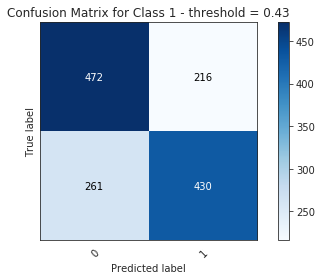

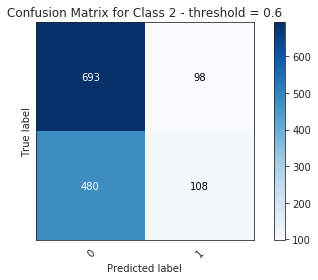

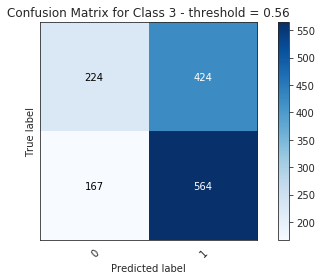

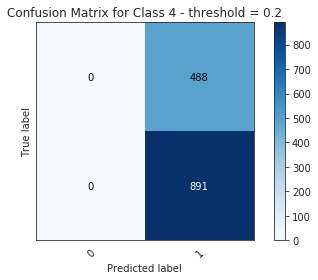

In [48]:
if use_aux_clf:
    for i in range(4):
        plot_confusion_matrix((present_classes[val_idx] > 0).astype(int)[:, i], 
                              (faults_pred > thresholds_aux[i]).astype(int)[:, i], 
                              title=f'Confusion Matrix for Class {i+1} - threshold = {thresholds_aux[i]}', 
                              normalize=False)

In [49]:
thresholds_max = tweak_thresholds_clf(faults_max, present_classes[val_idx])
thresholds_max

array([0.22, 0.26, 0.22, 0.41])

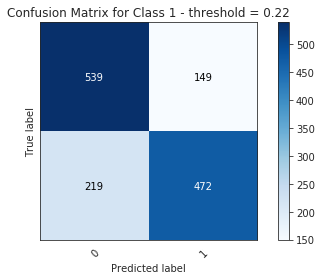

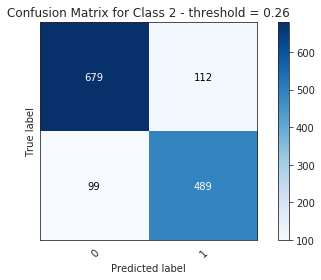

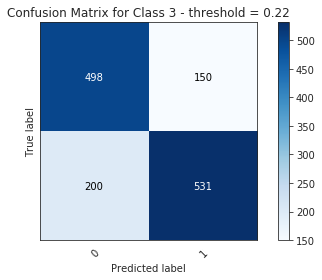

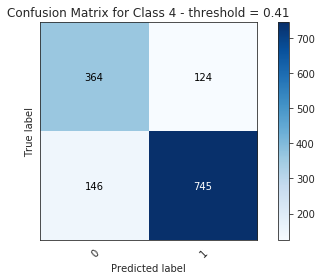

In [50]:
for i in range(4):
    plot_confusion_matrix((present_classes[val_idx] > 0).astype(int)[:, i], 
                          (faults_max > thresholds_max[i]).astype(int)[:, i], 
                          title=f'Confusion Matrix for Class {i+1} - threshold = {thresholds_max[i]}', 
                          normalize=False)

# Mask processing

In [52]:
thresholds = np.arange(0.3, 0.51, 0.1)
min_sizes = np.arange(5000, 20001, 5000)

In [53]:
thresholds = [0.4]
min_sizes = [10000]

In [54]:
def tweak_thresholds(image_names, mask_dic, probs, probs_max, truth_size=VAL_SHAPE, pred_path=MASKS_PATH, sub_shape=SUB_SHAPE,
                     thresholds=[0.5], min_sizes=[0], prob_thresholds=(0, 0, 0, 0), thresholds_max=(0, 0, 0, 0)):

    dices = {i: {threshold: 
                 {min_size: 0 for min_size in min_sizes} for threshold in thresholds} for i in range(4)}

    for i, name in enumerate(tqdm(image_names)):
        
        pred = cv2.imread(pred_path + name[:-4] + '.png', cv2.IMREAD_UNCHANGED) / 255
        pred = (pred.transpose(2, 0, 1))
        
        truth = get_masks(name, mask_dic, shape=truth_size)
        truth = cv2.resize(truth, (sub_shape[1], sub_shape[0])).transpose(2, 0, 1)

        for threshold in thresholds:
            for min_size in min_sizes:
                processed_masks = []
                for j, mask in enumerate(pred):
                    if probs[i, j] < prob_thresholds[j]:
                        processed_mask = np.zeros(sub_shape)
                    elif probs_max[i, j] < thresholds_max[j]:
                        processed_mask = np.zeros(sub_shape)
                    else:
                        if min_size > 0:
                            processed_mask = post_process(mask, threshold=threshold, min_size=min_size)
                        else:
                            processed_mask = (mask > threshold).astype(int)

                    dices[j][threshold][min_size] += dice_np(np.array([processed_mask]), truth[j:j+1]) / len(image_names)

    return dices


In [55]:
def dice_np(pred, truth, eps=1e-8, threshold=0.5):
    if len(truth.shape) == 4:
        n, c = truth.shape[0], pred.shape[1]
    else:
        n, c = truth.shape[0], 1
    
    pred = (pred.reshape((n * c, -1)) > threshold).astype(int)
    truth = (truth.reshape((n * c, -1)) > threshold).astype(int)

    intersect = (pred + truth == 2).sum(-1)
    union = pred.sum(-1) + truth.sum(-1)

    return ((2.0 * intersect + eps) / (union + eps)).mean()

In [56]:
dices = tweak_thresholds(all_images[val_idx], mask_dic, faults_pred, faults_max, truth_size=VAL_SHAPE, pred_path=MASKS_PATH, 
                         sub_shape=SUB_SHAPE, thresholds=thresholds, min_sizes=min_sizes, thresholds_max=thresholds_max,
                         prob_thresholds=thresholds_aux)

In [57]:
best_threshold, best_min_size, score = get_best_params(dices, thresholds, min_sizes)

Local validation dice is 0.6191

 -> Class 1 : 0.6144
 -> Class 2 : 0.6206
 -> Class 3 : 0.6038
 -> Class 4 : 0.6376


In [58]:
best_threshold = np.array(best_threshold)
best_min_size = np.array(best_min_size)

print('Best thresholds :', best_threshold)
print('Best min_sizes :', best_min_size)

Best thresholds : [0.4 0.4 0.4 0.4]
Best min_sizes : [10000. 10000. 10000. 10000.]


# Testing

In [79]:
models = []
backbone = 'se_resnext50_32x4d'

In [80]:
for selected_fold in range(k):
    weights =  f'unet_se_resnext50_32x4d_{selected_fold + 1}_2_shadow_cp.pt'
    
    try:
        model = SegmentationUnet(SETTINGS[backbone], num_classes=4, center_block="aspp", aux_clf=True).to(DEVICE)
        model = load_model_weights(model, weights, verbose=1, cp_folder=CP_FOLDER)

        models.append(model)
    except:
        
        print(weights, 'not available')


 -> Loading weights from ../checkpoints/used_cps/v3/unet_se_resnext50_32x4d_1_2_shadow_cp.pt


 -> Loading weights from ../checkpoints/used_cps/v3/unet_se_resnext50_32x4d_2_2_shadow_cp.pt


 -> Loading weights from ../checkpoints/used_cps/v3/unet_se_resnext50_32x4d_3_2_shadow_cp.pt


 -> Loading weights from ../checkpoints/used_cps/v3/unet_se_resnext50_32x4d_4_2_shadow_cp.pt



## Loading data

In [81]:
sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [82]:
df_test = pd.read_csv(DATA_PATH + 'sample_submission.csv')
df_test['EncodedPixels'].fillna('-1', inplace=True)
df_test['Image'] = df_test['Image_Label'].apply(lambda x: x.split('_')[0])
test_images = df_test['Image'].values[::4]

print('Number of testing images : ', len(test_images))

Number of testing images :  3698


In [83]:
MASKS_PATH_TEST = f'../masks_test/{date.today()}_{selected_fold + 1}/'
if not os.path.exists(MASKS_PATH_TEST):
    os.mkdir(MASKS_PATH_TEST)

## Dataset

In [95]:
test_dataset = CloudTestDataset(test_images, get_transfos(test=True), img_path=TEST_IMG_PATH)

## Predict

In [97]:
k = 4

In [98]:
fpt, fmt = [], []
MASKS_PATH_TESTS = [f'../masks_test/{date.today()}_{selected_fold + 1}_2/' for selected_fold in range(k)]

for mp in MASKS_PATH_TESTS:
    if not os.path.exists(mp):
        os.mkdir(mp)

In [99]:
test_dataset

In [ ]:
for i in range(k):
    print(f"Saving to {MASKS_PATH_TESTS[i]}")
    faults_pred_test, faults_max_test = predict_and_save(test_dataset, models[i], test_images, tta=tta, 
                                                         img_folder=MASKS_PATH_TESTS[i])
    fpt.append(faults_pred_test)
    fmt.append(faults_max_test)

In [113]:
fpt = np.load(f'../output/fpt_2019-11-12.npy')
fpt = np.array(fpt).mean(0)

In [114]:
fpt.shape

(3698, 4)

In [103]:
test_prob_dic = {}

for img, p in zip(test_images, fpt):
    test_prob_dic[img] = p

In [104]:
CP_FOLDER

'../checkpoints/used_cps/v3/'

In [105]:
with open(f'{CP_FOLDER}test_probs_dic.pickle', 'wb') as handle:
    pickle.dump(test_prob_dic , handle, protocol=pickle.HIGHEST_PROTOCOL)

In [106]:
# fpt = np.array(fpt)
# fmt = np.array(fmt)

# np.save(f'../output/fpt_{date.today()}.npy', fpt)
# np.save(f'../output/fmt_{date.today()}.npy', fmt)

## Generate Rles

In [107]:
def get_rles(image_names, probs, pred_path=MASKS_PATH_TEST, sub_shape=SUB_SHAPE,
             thresholds=(0.5, 0.5, 0.5, 0.5), min_sizes=(0, 0, 0, 0), prob_thresholds=(0, 0, 0, 0)):

    rles = []

    for i, name in enumerate(tqdm(image_names)):
        
        pred = cv2.imread(pred_path + name[:-4] + '.png', cv2.IMREAD_UNCHANGED) / 255
        pred = (pred.transpose(2, 0, 1))
        
        processed_masks = []
        for j, mask in enumerate(pred):
            if probs[i, j] < prob_thresholds[j]:
                processed_mask = np.zeros(sub_shape)
            else:
                if min_sizes[j] > 0:
                    processed_mask = post_process(mask, threshold=thresholds[j], min_size=min_sizes[j])
                else:
                    processed_mask = (mask > thresholds[j]).astype(int)
            
            rles += [mask_to_rle(processed_mask)]

    return rles


In [108]:
thresholds_aux = [0.5, 0.5, 0.5, 0.5]
thresholds_aux = [0] * 4
best_threshold = [0.4, 0.4, 0.4, 0.4]
best_min_size = [10000, 10000, 10000, 10000]

In [117]:
faults_pred_test = fpt.mean(0)
MASKS_PATH_TEST = MASKS_PATH_TESTS[0]

In [ ]:
rles_test = get_rles(test_images, faults_pred_test, MASKS_PATH_TEST, sub_shape=SUB_SHAPE,
                     thresholds=best_threshold, min_sizes=best_min_size, 
                     prob_thresholds=thresholds_aux
                    )

In [119]:
print(f'Loading masks from {MASKS_PATH_TEST}')
print('Using thresholds :', best_threshold)
print('Using min_sizes :', best_min_size)
print('Using prob_thresholds :', thresholds_aux)

Loading masks from ../masks_test/2020-02-22_1_2/
Using thresholds : [0.4, 0.4, 0.4, 0.4]
Using min_sizes : [10000, 10000, 10000, 10000]
Using prob_thresholds : [0, 0, 0, 0]


## Ensembling

In [193]:
def get_rles_vote(image_names, probs, pred_paths, thresholds, min_sizes, prob_thresholds, 
                  sub_shape=SUB_SHAPE, vote_threshold=0.5):
    rles = []

    for i, name in enumerate(tqdm(image_names)):
        for model_idx, pred_path in enumerate(pred_paths):
            processed_masks = [[], [], [], []]
            pred = cv2.imread(pred_path + name[:-4] + '.png', cv2.IMREAD_UNCHANGED) / 255
            pred = (pred.transpose(2, 0, 1))
            
            for j, mask in enumerate(pred):
                if probs[model_idx, i, j] < prob_thresholds[model_idx, j]:
                    processed_mask = np.zeros(sub_shape)
                else:
                    if min_sizes[model_idx, j] > 0:
                        processed_mask = post_process(mask, threshold=thresholds[model_idx, j], 
                                                      min_size=min_sizes[model_idx, j])
                    else:
                        processed_mask = (mask > thresholds[model_idx, j]).astype(int)
                processed_masks[j].append(processed_mask)
                
        for pms in processed_masks:
            processed_mask = (np.mean(np.array(pms), axis=0) > vote_threshold).astype(int)
            rles += [mask_to_rle(processed_mask)]

    return rles

In [128]:
def get_rles_mean(image_names, probs, pred_paths, thresholds, min_sizes, prob_thresholds, 
                  sub_shape=SUB_SHAPE):
    rles = []

    for i, name in enumerate(tqdm(image_names)):
        preds = []
        for model_idx, pred_path in enumerate(pred_paths):
            processed_masks = [[], [], [], []]
            pred = cv2.imread(pred_path + name[:-4] + '.png', cv2.IMREAD_UNCHANGED) / 255
            pred = (pred.transpose(2, 0, 1))
            preds.append(pred)
        pred = np.mean(np.array(preds), axis=0)
        
        for j, mask in enumerate(pred):
            if probs[model_idx, i, j] < prob_thresholds[model_idx, j]:
                processed_mask = np.zeros(sub_shape)
            else:
                if min_sizes[model_idx, j] > 0:
                    processed_mask = post_process(mask, threshold=thresholds[model_idx, j], 
                                                  min_size=min_sizes[model_idx, j])
                else:
                    processed_mask = (mask > thresholds[model_idx, j]).astype(int)
            rles += [mask_to_rle(processed_mask)]          

    return rles

In [129]:
prob_thresholds = 0.5 * np.ones((len(MASKS_PATH_TESTS), 4))
thresholds = 0.4 * np.ones((len(MASKS_PATH_TESTS), 4))
min_sizes = 10000 * np.ones((len(MASKS_PATH_TESTS), 4))

In [130]:
# rles_test = get_rles_vote(test_images, probs=fpt, pred_paths=MASKS_PATH_TESTS,
#                           thresholds=thresholds,
#                           min_sizes=min_sizes,
#                           prob_thresholds=prob_thresholds,
#                           sub_shape=SUB_SHAPE,
#                           vote_threshold=0.5)

In [131]:
MASKS_PATH_TESTS = ['../masks_test/2019-11-15_1_2/', '../masks_test/2019-11-15_1/']

In [132]:
thresholds, min_sizes, prob_thresholds

(array([[0.4, 0.4, 0.4, 0.4],
        [0.4, 0.4, 0.4, 0.4]]), array([[10000., 10000., 10000., 10000.],
        [10000., 10000., 10000., 10000.]]), array([[0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5]]))

In [ ]:
rles_test = get_rles_mean(test_images, probs=fpt, pred_paths=MASKS_PATH_TESTS,
                          thresholds=thresholds, min_sizes=min_sizes,
                          prob_thresholds=prob_thresholds, sub_shape=SUB_SHAPE)

## Submission

In [134]:
score = '0.6x3'

In [135]:
sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [136]:
SUB_PATH = f'../subs/{date.today()}/'

if not os.path.exists(SUB_PATH):
    os.mkdir(SUB_PATH)

In [137]:
sub_name = f'{score}.csv'

In [ ]:
sub['EncodedPixels'] = rles_test

In [200]:
sub.to_csv(SUB_PATH + sub_name, index=False)

In [201]:
sub.head(10)

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,6 336 353 342 702 344 1051 346 1401 347 1751 3...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,
5,0035ae9.jpg_Flower,
6,0035ae9.jpg_Gravel,69 213 300 30 414 276 763 279 1112 281 1461 28...
7,0035ae9.jpg_Sugar,306 34 583 112 929 117 1277 120 1625 123 1974 ...
8,0038327.jpg_Fish,
9,0038327.jpg_Flower,


## Vizualising predictions

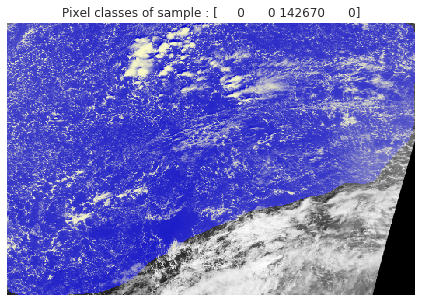

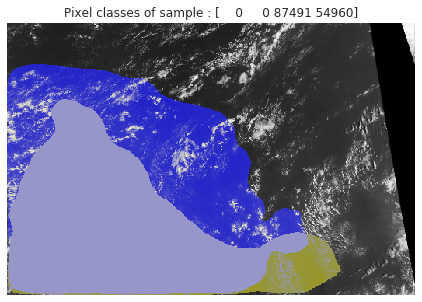

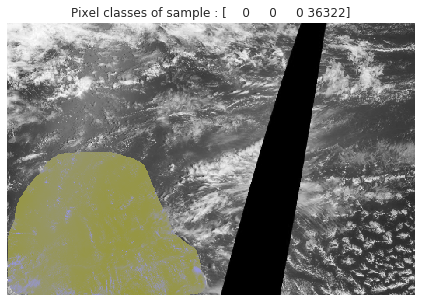

In [127]:
for i in range(3):
    pred = cv2.imread(MASKS_PATH_TEST + test_images[i][:-3] + 'png', cv2.IMREAD_UNCHANGED) / 255
    pred = (pred.transpose(2, 0, 1) > 0.5).astype(int)

    img, truth, c = test_dataset[i]
    test_img = cv2.resize(img.transpose(1, 2, 0), (525, 350)).transpose(2, 0, 1)
    plot_masks(test_img[0], pred)